install torch with cuda

https://pytorch.org/get-started/locally/

https://visualstudio.microsoft.com/pt-br/visual-cpp-build-tools/

In [1]:
# import torch
# torch.cuda.is_available()

# import os
# print(os.environ.get('CUDA_PATH'))

# conda install -c conda-forge cudatoolkit-dev -y

# export CUDA_HOME=/path/to/cuda-11.3/

In [2]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import torch
from PIL import Image
import numpy as np
from torchvision.ops import box_convert
import cv2
from IPython.display import display


In [5]:
model = load_model("../../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "../../GroundingDINO/weights/groundingdino_swint_ogc.pth")

/opt/homebrew/Caskroom/miniforge/base/envs/dino/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [6]:
IMAGE_PATH = "imagens/01.jpg"
TEXT_PROMPT = "car"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

In [8]:
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device= 'cpu' #mudar caso esteja com CUDA habilitado
)

/opt/homebrew/Caskroom/miniforge/base/envs/dino/lib/python3.11/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/dino/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/dino/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


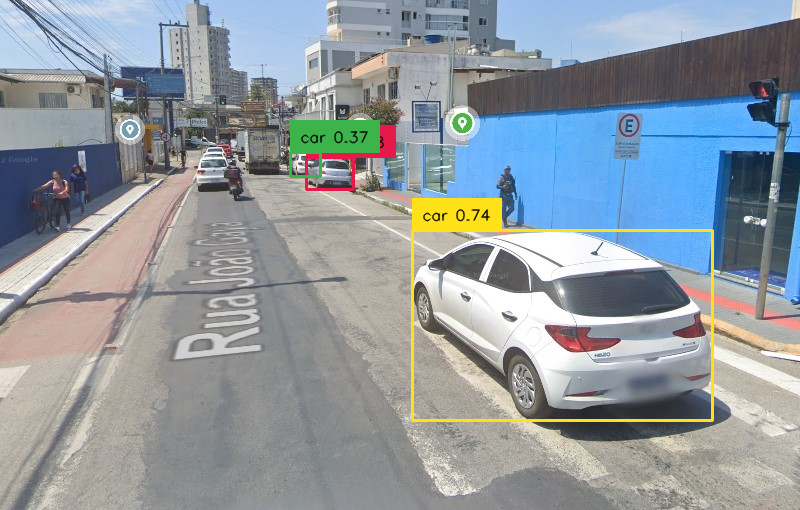

In [17]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

# salvar a imagem anotada
# cv2.imwrite("resultados/annotated_image.jpg", annotated_frame)

annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(annotated_frame_rgb)
display(pil_img)

In [10]:
def generate_masks_with_grounding(image_source, boxes):
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0, x1, y1 = box
        mask[int(y0):int(y1), int(x0):int(x1), :] = 255
    return mask

In [11]:
image_mask = generate_masks_with_grounding(image_source, boxes)

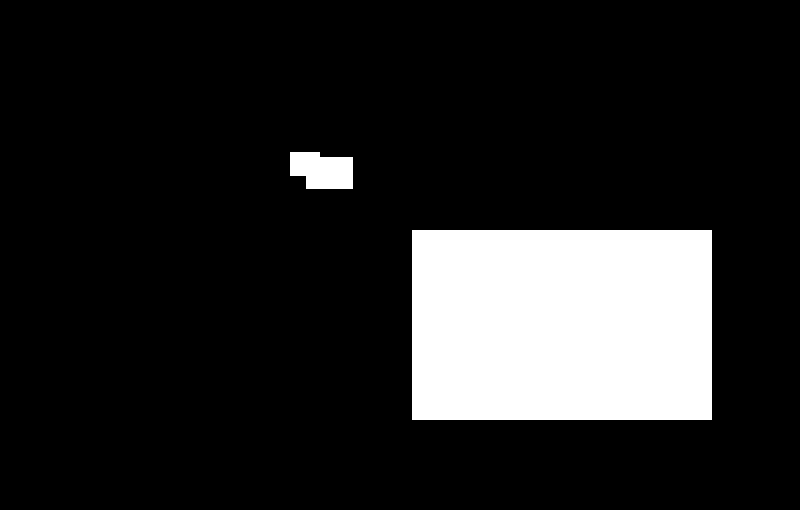

In [12]:
Image.fromarray(image_mask)

In [13]:
# %%
def find_largest_mask(mask):
    # Encontrar contornos na máscara
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Área máxima inicial e contorno da maior máscara
    max_area = 0
    largest_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour
    return largest_contour


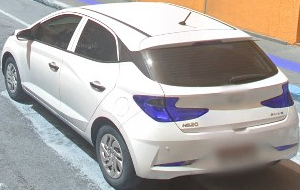

Imagem recortada salva e exibida com sucesso.


In [18]:
# Encontrar a maior máscara
gray_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)
largest_contour = find_largest_mask(gray_mask)

# Verificar se um contorno foi encontrado
if largest_contour is not None:
    x, y, w, h = cv2.boundingRect(largest_contour)
    # Recortar a imagem original com base no contorno da maior máscara
    cropped_image = image_source[y:y+h, x:x+w]
    # Salvar a imagem recortada
    cv2.imwrite('resultados/cropped_image.jpg', cropped_image)

    # Converter a imagem recortada para o formato RGB
    cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    # Criar um objeto Image do PIL a partir do array
    pil_cropped_img = Image.fromarray(cropped_image_rgb)
    # Exibir a imagem no notebook
    display(pil_cropped_img)

    print("Imagem recortada salva e exibida com sucesso.")
else:
    print("Nenhuma máscara grande encontrada.")